<a href="https://colab.research.google.com/github/stirlitzzz/markov_switching_demo/blob/main/MarkovRegimes_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Imports for JupyterLite
import ipywidgets as widgets
from datetime import datetime
from pandas.io.stata import relativedelta
from IPython.display import display

Label Bear and Bull markets.

In [ ]:
def labelBullBearMarket(ts):
    """
    ts: a time series
    result: a time series of labeled market states (0: bear, 1: bull)
    1. Given that the last observed extreme was a local maximum, referred to as P max , the subsequent price series is checked against the following criteria:
            a) The peak is updated if the stock market has risen above the last peak.
            b) A local minimum has been found if the stock market has fallen by 10% or more.
            c) There are no updates if neither a) nor b) took place.
            2. Given that the last observed extreme was a local minimum, referred to as P min, the subsequent price series is checked against the following criteria:
            a) The trough is updated if the stock market has dropped below the last minimum.
            b) A peak has been found if the stock market has risen by 15% or more.
            c) There are no updates if neither a) nor b) took place.
    """
    last_max=ts[0]
    last_min=ts[0]
    last_extreme_regime=1
    last_regime_index=0
    result=np.zeros(len(ts))
    for i in range(1,len(ts)):
        if last_extreme_regime==1:
            if ts[i]>last_max:
                last_max=ts[i]
                result[last_regime_index:i]=1
                last_regime_index=i

            elif ts[i]<last_max*0.9:
                last_min=ts[i]
                last_extreme_regime=0
                result[last_regime_index:i]=0
                last_regime_index=i
        else:
            if ts[i]<last_min:
                last_min=ts[i]
                result[last_regime_index:i]=0
                last_regime_index=i
            elif ts[i]>last_min*1.15:
                last_max=ts[i]
                last_extreme_regime=1
                result[last_regime_index:i]=1
                last_regime_index=i


    return result

Load SPX historical Data:
- This is daily data, but I would want to run it on weekly
- What is the best way to resample 
- I want to have also load the OECD data and resample them together

In [ ]:
spx_data_all=pd.read_csv('https://raw.githubusercontent.com/stirlitzzz/markov_switching_demo/main/SPX_1980_historical_data.csv', index_col='Date')
spx_data_all.index=pd.to_datetime(spx_data_all.index)
spx_data_all.Close=pd.to_numeric(spx_data_all.Close)
ts_regime=labelBullBearMarket(spx_data_all.Close)
spx_data_all["Date"]=spx_data_all.index
spx_data_all["Regime"]=ts_regime


In [ ]:
oecd_raw_data=pd.read_csv('https://raw.githubusercontent.com/stirlitzzz/OECD_demo/main/OECD_indicators_raw.csv')
#first step is to set up the pivot table
oecd_pivot=pd.pivot_table(oecd_raw_data,values='Value',index='TIME', columns='LOCATION', aggfunc=np.mean)
#find the average value for each time slice
oecd_index=oecd_pivot.mean(axis=1)/100
#Compute the diffusion index (percent of location with CLI index up month over month)
oecd_monthly_diffs=oecd_pivot.diff(axis=0)
a=oecd_monthly_diffs>0
b=oecd_monthly_diffs<=0
oecd_monthly_diffusion_index=a.sum(axis=1)/(a.sum(axis=1)+b.sum(axis=1))
#make a copy of the original series, change the index to datetime, and move forward by 15 days
oecd_diffusion_dates=[datetime.strptime(x, '%Y-%m')+relativedelta(months=1)+relativedelta(days=14) for x in oecd_monthly_diffusion_index.index]
oecd_monthly_diffusion_index.index=oecd_diffusion_dates

In [ ]:
oecd_downsampled_diffusion=oecd_monthly_diffusion_index.resample('W-Mon').ffill()
spx_downsampled_data=spx_data_all.resample('W-Mon').last() 
spx_downsampled_data=spx_downsampled_data[["Close"]]
oecd_downsampled_diffusion
df_oecd_daily=pd.DataFrame(oecd_downsampled_diffusion)
df_oecd_daily.columns=["oecd_diffusion"]
df_oecd_daily.index.name="Date"

spx_oecd=spx_downsampled_data.merge(df_oecd_daily,left_index=True,right_index=True)
spx_oecd["oecd_diffusion_lag"]=spx_oecd["oecd_diffusion"].shift(periods=1)
ts_regime=labelBullBearMarket(spx_oecd.Close)
spx_oecd["Regime"]=ts_regime

spx_oecd["return"]=spx_oecd["Close"]/spx_oecd["Close"].shift(periods=1)-1
df_returns=spx_oecd["return"]
df_diffusion_ind=spx_oecd["oecd_diffusion"]

Plot all of the data

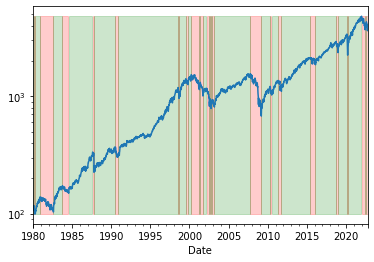

In [ ]:
#spx_data=spx_data_all
spx_data=spx_oecd
y_min,y_max=spx_data.Close.min(),spx_data.Close.max()
ax=spx_data.Close.plot()
ax.fill_between(spx_data.Close.index, y_min,y_max, where=(spx_data.Regime==0), color='red',alpha=0.2)
ax.fill_between(spx_data.Close.index, y_min,y_max, where=(spx_data.Regime==1), color='green',alpha=0.2)
plt.yscale('log')
plt.show()

Do in-sample classification

In [ ]:
num_regimes=2
sample_end=2230
probs_out=[]
probs_tvtp_out=[]
for j in range(num_regimes):
    regime_prob=[]
    regime_tvtp_prob=[]
    probs_out.append(regime_prob)
    probs_tvtp_out.append(regime_tvtp_prob)

mod_sm_fixed = sm.tsa.MarkovRegression(
    df_returns.to_numpy()[1:sample_end], k_regimes=num_regimes, trend="c", switching_variance=True, switching_trend=True)
    #print("i={}".format(i))
res_fixed = mod_sm_fixed.fit()
    #res_fixed.summary()
mod_sm_tvtp = sm.tsa.MarkovRegression(
    df_returns.to_numpy()[1:sample_end], k_regimes=num_regimes, trend="c", switching_variance=True, switching_trend=True,exog_tvtp=df_diffusion_ind.to_numpy()[1:sample_end])
res_tvtp = mod_sm_tvtp.fit()
for j in range(num_regimes):
    probs=res_fixed.smoothed_marginal_probabilities[:,j]
    probs_tvtp=res_tvtp.smoothed_marginal_probabilities[:,j]
    probs_out[j]=probs
    probs_tvtp_out[j]=probs_tvtp

In [ ]:
df_returns.shape[0]

2234

In [ ]:
df_output=spx_oecd
df_output
num_dates=spx_oecd.shape[0]

df_output["prob_zero"] =np.pad(probs_out[0],(0,num_dates-sample_end+1),'constant', constant_values=(0, 0))
df_output["prob_one"] =np.pad(probs_out[1],(0,num_dates-sample_end+1),'constant', constant_values=(0, 0))
df_output["prob_tvtp_zero"] =np.pad(probs_tvtp_out[0],(0,num_dates-sample_end+1),'constant', constant_values=(0, 0))
df_output["prob_tvtp_one"] =np.pad(probs_tvtp_out[1],(0,num_dates-sample_end+1),'constant', constant_values=(0, 0))
df_output



,Close,oecd_diffusion,oecd_diffusion_lag,Regime,return,prob_zero,prob_one,prob_tvtp_zero,prob_tvtp_one
Date,,,,,,,,,
1979-12-31,107.90,0.227273,NaN,1.0,NaN,0.828562,0.171438,0.778491,0.221509
1980-01-07,106.80,0.227273,0.227273,1.0,-0.010195,0.819676,0.180324,0.702416,0.297584
1980-01-14,110.40,0.227273,0.227273,1.0,0.033708,0.833699,0.166301,0.818273,0.181727
1980-01-21,112.10,0.181818,0.227273,1.0,0.015399,0.823369,0.176631,0.814753,0.185247
1980-01-28,114.80,0.181818,0.181818,1.0,0.024086,0.804891,0.195109,0.858994,0.141006
...,...,...,...,...,...,...,...,...,...
2022-09-19,3899.89,0.000000,0.047619,0.0,-0.051216,0.000000,0.000000,0.000000,0.000000
2022-09-26,3655.04,0.000000,0.000000,0.0,-0.062784,0.000000,0.000000,0.000000,0.000000
2022-10-03,3678.43,0.000000,0.000000,0.0,0.006399,0.000000,0.000000,0.000000,0.000000


Read the file and display

In [ ]:
filter_turning_point=(df_output.Regime!=df_output.Regime.shift(1))
df_turning_points=df_output.loc[filter_turning_point].copy()
df_turning_points=df_turning_points[["Close","Regime","oecd_diffusion","oecd_diffusion_lag"]]
df_turning_points["Performance"]=df_turning_points.Close.shift(-1)/df_turning_points.Close-1
df_turning_points["Start_Date"]=df_turning_points.index
#df_turning_points["Duration"]=df_turning_points.Start_Date.shift(-1)-df_turning_points.Start_Date
df_turning_points["End_Date"]=df_turning_points.Start_Date.shift(-1)
df_turning_points["Prev_Start_Date"]=df_turning_points.Start_Date.shift(1)  
df_turning_points["Prev_Start_Date"][0]=df_turning_points["Start_Date"][0]
regime_codes={0:"Bear",1:"Bull"}
regime_codes_reverse={v:k for k,v in regime_codes.items()}
with pd.ExcelWriter('output.xlsx') as writer:  
    df_output.to_excel(writer, sheet_name='In_sample_class')
    df_turning_points.to_excel(writer, sheet_name='regime_periods')
#df_turning_points


<ipython-input-10-1ff91db9d7a5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_turning_points["Prev_Start_Date"][0]=df_turning_points["Start_Date"][0]


1) filter the regimes
2) number the regimes
3) put a regime scroller

In [ ]:
df_turning_points_use=df_turning_points
num_periods=df_turning_points_use.shape[0]
df_turning_points_use["Name"]=range(0,num_periods)
df_turning_points_use
df_output.Close

Date
1979-12-31     107.90
1980-01-07     106.80
1980-01-14     110.40
1980-01-21     112.10
1980-01-28     114.80
               ...   
2022-09-19    3899.89
2022-09-26    3655.04
2022-10-03    3678.43
2022-10-10    3612.39
2022-10-17    3677.95
Freq: W-MON, Name: Close, Length: 2234, dtype: float64

In [ ]:

w_play_start_index=widgets.Play(
    value=0,
    min=0,
    max=num_periods-1,
    step=1,
    description="Press play",
    interval=2000,
    disabled=False
)

w_slider = widgets.IntSlider(
    min=0,
    max=num_periods-1,
    step=1,
    continuous_update=True,
    disabled=False
)
w_display = widgets.Output(layout = widgets.Layout(height='900px'))
widgets.jslink((w_play_start_index, 'value'), (w_slider, 'value'))
def select_roi(p_loc):
    roi_start_date=df_turning_points_use.Start_Date[p_loc]
    roi_end_date=df_turning_points_use.End_Date[p_loc]
    roi_prev_start_date=df_turning_points_use.Prev_Start_Date[p_loc]
    df_output_roi=df_output[roi_prev_start_date:roi_end_date]
    return df_output_roi


#with w_display:


def play_value_change(change):
    p_loc=w_play_start_index.value
    w_period_label.value="Period ={} Start_Date={}, End Date= {}".format(p_loc,df_turning_points_use.iloc[p_loc]["Start_Date"],df_turning_points_use.iloc[p_loc]["End_Date"])
    df_output_roi=select_roi(p_loc)
    #print("df_output={}".format(df_output_roi))

    with w_display:
        w_display.clear_output()
        fig, ax = plt.subplots(3, 1, figsize=(10, 10))
        #fig, ax = plt.subplots(2, 1, figsize=(10, 10))

        spx_data=spx_oecd
        y_min,y_max=spx_data.Close.min(),spx_data.Close.max()
        ax[0].plot(spx_data.index,spx_data.Close)
        ax[0].fill_between(spx_data.index, y_min,y_max, where=(spx_data.Regime==0), color='red',alpha=0.06)
        ax[0].fill_between(spx_data.index, y_min,y_max, where=(spx_data.Regime==1), color='green',alpha=0.06)
        ax[0].fill_between(df_output_roi.index, y_min,y_max, where=(df_output_roi.Regime==0), color='red',alpha=0.3)
        ax[0].fill_between(df_output_roi.index, y_min,y_max, where=(df_output_roi.Regime==1), color='green',alpha=0.3)
        ax[0].set_yscale('log')
        #plt.yscale('log')
        #plt.show()
        y_min,y_max=df_output_roi.Close.min(),df_output_roi.Close.max()
        ax[1].plot(df_output_roi.index,df_output_roi.Close)
        ax[2].plot(df_output_roi.index,df_output_roi.prob_one)
        ax[2].plot(df_output_roi.index,df_output_roi.prob_tvtp_one)
        ax[2].plot(df_output_roi.index,df_output_roi.oecd_diffusion)
        ax[1].fill_between(df_output_roi.Close.index, y_min,y_max, where=(df_output_roi.Regime==0), color='red',alpha=0.1)
        ax[1].fill_between(df_output_roi.Close.index, y_min,y_max, where=(df_output_roi.Regime==1), color='green',alpha=0.1)

        ax[2].fill_between(df_output_roi.Close.index, 0,1, where=(df_output_roi.Regime==0), color='red',alpha=0.1)
        ax[2].fill_between(df_output_roi.Close.index, 0,1, where=(df_output_roi.Regime==1), color='green',alpha=0.1)
        #print("bla")
        plt.show()

w_play_start_index.observe(play_value_change, names='value')

w_period_label = widgets.Label(value="Period ={} Start_Date={}, End Date= {}".format(0,df_turning_points_use.iloc[0]["Start_Date"],df_turning_points_use.iloc[0]["End_Date"]))
from IPython.display import HTML
display(HTML('''<link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css"> '''))
display(widgets.VBox([widgets.HBox([w_play_start_index,w_slider]),w_period_label, w_display]))



In [ ]:
num_points=df_returns.shape[0]
#df_returns[0:num_points]
def ClassifyLastPoint(df,df_diffusion):
    """
    """
    dOut={}
    mod_sm_fixed = sm.tsa.MarkovRegression(
        df.to_numpy()[1:], k_regimes=num_regimes, trend="c", switching_variance=True, switching_trend=True)
    res_fixed = mod_sm_fixed.fit()
    mod_sm_tvtp = sm.tsa.MarkovRegression(
        df.to_numpy()[1:], k_regimes=num_regimes, trend="c", switching_variance=True, switching_trend=True,exog_tvtp=df_diffusion.to_numpy()[1:])
    res_tvtp = mod_sm_tvtp.fit()


    dOut["tvtp_p_zero"]=res_tvtp.smoothed_marginal_probabilities[-1,0]
    dOut["fixed_p_zero"]=res_fixed.smoothed_marginal_probabilities[-1,0]

    dOut["tvtp_p_zz"]=res_tvtp.regime_transition[0,0,-1]
    dOut["tvtp_p_oo"]=res_tvtp.regime_transition[1,1,-1]
    dOut["fixed_p_zz"]=res_fixed.regime_transition[0,0,0]
    dOut["fixed_p_oo"]=res_fixed.regime_transition[1,1,0]
    dOut["fixed_mean_z"]=res_fixed.params[2]
    dOut["fixed_mean_o"]=res_fixed.params[3]
    dOut["tvtp_mean_z"]=res_tvtp.params[2]
    dOut["tvtp_mean_o"]=res_tvtp.params[3]
    dOut["fixed_std_z"]=np.sqrt(res_fixed.params[4])
    dOut["fixed_std_o"]=np.sqrt(res_fixed.params[5])
    dOut["tvtp_std_z"]=np.sqrt(res_tvtp.params[4])
    dOut["tvtp_std_o"]=np.sqrt(res_tvtp.params[5])

    dOut["Date"]=df.index[-1]
    return dOut

dOut=ClassifyLastPoint(df_returns,df_diffusion_ind)
display(dOut)


{'tvtp_p_zero': 0.6522093420210792,
 'fixed_p_zero': 0.421410703052743,
 'tvtp_p_zz': 0.5,
 'tvtp_p_oo': 0.5,
 'fixed_p_zz': 0.9712229700491953,
 'fixed_p_oo': 0.9277340344123199,
 'fixed_mean_z': 0.003124408810105005,
 'fixed_mean_o': -0.001187785189449124,
 'tvtp_mean_z': 0.002830252040228205,
 'tvtp_mean_o': -0.0012379023322639866,
 'fixed_std_z': 0.015723351040217656,
 'fixed_std_o': 0.03965563523895178,
 'tvtp_std_z': 0.016238527221579716,
 'tvtp_std_o': 0.04290616798714771,
 'Date': Timestamp('2022-10-17 00:00:00', freq='W-MON')}

In [ ]:
num_regimes=2
#hard code two regimes
first_end_point=1000
num_points=df_returns.shape[0]
#num_points=first_end_point+5
#res_tvtp.regime_transition[1,1,-1]

progress_bar=widgets.IntProgress(
    value=first_end_point,
    min=first_end_point,
    max=num_points-1,
    step=1,
    description='Loading:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)

progress_label=widgets.Label(value=("time "+str(first_end_point)+" out of "+str(num_points)))
display(widgets.HBox([progress_bar,progress_label]))

out_array=[]
for i in range(first_end_point,num_points):
    
    dOut=ClassifyLastPoint(df_returns[:i],df_diffusion_ind[:i])
    out_array.append(dOut)
    progress_bar.value += 1
    progress_label.value="time "+str(i)+" out of "+str(num_points)

progress_bar.bar_style = "success"
progress_bar.close()

df_out=pd.DataFrame.from_records(out_array)
df_out.index=df_out.Date

with pd.ExcelWriter('output_outsample.xlsx') as writer:  
    df_out.to_excel(writer, sheet_name='out_sample')

In [ ]:
len(df_out)

1234